# Mizzou Football Roster: HTML Web Scraper & EDA

This notebook explores the University of Missouri 2023 football roster (from the [SEC website](https://www.secsports.com/roster/football/missouri-tigers)) using `HTML` and `BeautifulSoup`. 

<div>
<img src="Missouri_Tigers_logo.svg.png" width="250"/>
</div>

In [1]:
# import packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Extracting data from HTML table

In [2]:
# retrieve the HTML
url = 'https://www.secsports.com/roster/football/missouri-tigers'
page = requests.get(url)

In [3]:
# find text content for table HTML element
table = BeautifulSoup(page.text).find('table')

# pull rows from table
all_trs =  table.tbody.find_all('tr')

# pull headers from table
all_ths = table.thead.find_all('th')

# return all headers as list
cols = [th.text for th in all_ths]

# pull data cells from table rows
all_tds = [tr.find_all('td') for tr in all_trs]

# return all row content from data cells
rows = [[td.text for td in row] for row in all_tds]

# create df from rows and columns
data = pd.DataFrame(data = rows, columns = cols)

## Data Cleaning & Transformation

In [4]:
# preview data
data.head()

,NO,NAME,POS,HT,WT,CLASS,HOMETOWN
0,#0,BJ Harris,RB,"5'-9""",214,SO,"Chattanooga, TN"
1,#0,Jayden Jernigan,DL,"6'-0""",277,JR,"Allen, TX"
2,#1,Jaylon Carlies,DB,"6'-3""",219,JR,"Orlando, FL"
3,#1,Tauskie Dove,WR,"6'-2""",194,SR,"Denton, TX"
4,#2,Chance Luper,WR,"6'-2""",189,SO,"Dallas, TX"


In [5]:
# rename columns
data.columns = ['number', 'name', 'position', 'height', 'weight', 'class', 'home']

# remove '#' character from number column
data['number'] = data['number'].str.replace(r'\D', '').astype(int)

# create seperate columns for home town and state
data['home_town'] = data['home'].str.split(',').str[0]
data['home_state'] = data['home'].str.split(',').str[1]

In [6]:
# calculate height in inches

# replace '-' will null
data = data.replace('-', np.NaN)

# seperate feet and inches into seperate temp columns
data['height_ft_temp'] = data['height'].str.split('-').str[0].str.replace("'", "")
data['height_in_temp'] = data['height'].str.split('-').str[-1].str.split('"').str[0]

# calculate height
data['height_inch'] = (data['height_ft_temp'].fillna(0).astype(int) * 12) + (data['height_in_temp'].fillna(0).astype(int))

# drop temp columns
data = data.drop(['height_ft_temp', 'height_in_temp'], axis=1)

data['height_inch'] = data['height_inch'].replace(0, np.NaN)

In [7]:
# create weight categories

data['weight_cat'] = data['weight'].astype(np.float).astype('Int32')

data.loc[:, 'weight_cat'] = pd.cut(x = data['weight_cat'], bins = [0, 220, 270, 400]
                                           , labels = ['light', 'average', 'heavy'])

data['weight_cat'] = data['weight_cat'].cat.reorder_categories(['light', 'average', 'heavy'])

In [8]:
# create height categories

data['height_cat'] = data['height_inch'].astype(np.float).astype('Int32')

data.loc[:, 'height_cat'] = pd.cut(x = data['height_cat'], bins = [0, 66, 69, 90]
                                           , labels = ['short', 'average', 'tall'])

data['height_cat'] = data['height_cat'].cat.reorder_categories(['short', 'average', 'tall'])

In [9]:
# calculate bmi
data['bmi'] = (data['weight'].fillna(0).astype(int) / (data['height_inch'].fillna(0).astype(int) * data['height_inch'].fillna(0).astype(int))) * 703

## Data Exploration

In [10]:
# count of each position
data.groupby('position')['name'].count().sort_values(ascending = False)

# there are the players who play offensive line, least are defensive line and punter

position
OL    26
DB    21
DL    20
LB    11
RB    11
WR    11
TE     8
QB     6
K      4
LS     3
DE     1
P      1
Name: name, dtype: int64

In [11]:
# count of each class
data.groupby('class')['name'].count().sort_values(ascending = False)

# most platers are freshman, least are juniors and sophmores

class
FR    55
SR    26
JR    21
SO    21
Name: name, dtype: int64

In [12]:
# count of players by state
data.groupby('home_state')['name'].count().sort_values(ascending = False)

# most players are from Missouri, not surprising

home_state
 MO    41
 TX    12
 GA    10
 FL     7
 TN     5
 IL     5
 NC     4
 KS     3
 LA     3
 AL     3
 IN     3
 CA     3
 MI     3
 AR     2
 MS     2
 OH     2
 OK     2
 AZ     2
 ID     1
 CO     1
 NE     1
 NJ     1
 PA     1
 SC     1
Name: name, dtype: int64

In [13]:
# count of players by home state and city
data.groupby(['home_state', 'home_town'])['name'].count().sort_values(ascending = False).head(15)

home_state  home_town    
 MO         Saint Louis      15
            Columbia          6
 TX         Dallas            4
 MO         Lee's Summit      4
 KS         Overland Park     3
 TX         Allen             3
 GA         Atlanta           3
 TX         Houston           2
 IL         Chicago           2
 TN         Memphis           2
 IN         Indianapolis      2
 MI         Detroit           2
 FL         Orlando           2
 MO         Weldon Spring     1
            Washington        1
Name: name, dtype: int64

In [14]:
# percentage of players with another player from hometown
print(round(data.groupby(['home'])['name'].count().sort_values().loc[lambda x : x>1].sum() / data['name'].count() * 100, 2), '%', sep='')

40.65%


In [15]:
# count per weight classes
data['weight_cat'].value_counts()

# most players fall into the light weight class (less than 220 lbs)

light      51
heavy      36
average    31
Name: weight_cat, dtype: int64

In [16]:
# count per height class
data['height_cat'].value_counts()

# most players are in the tall height class (70 inches and above)

tall       107
average     11
short        0
Name: height_cat, dtype: int64

## Data Visualization

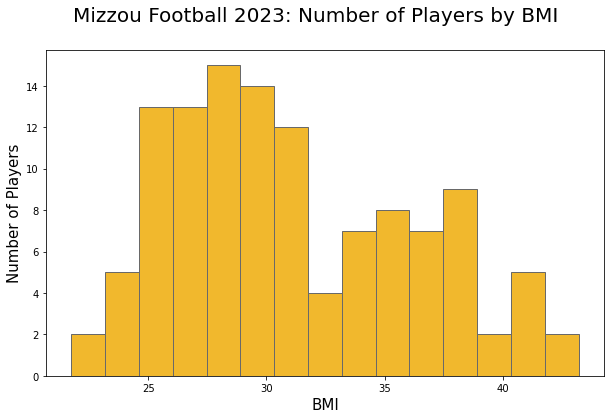

In [17]:
# BMI by number of players histogram
plt.figure(figsize=(10,6))
plt.hist(data['bmi'], bins = 15, color = '#F1B82D', edgecolor = 'dimgrey')
plt.suptitle('Mizzou Football 2023: Number of Players by BMI', fontsize = 20)
plt.xlabel("BMI", fontsize = 15)
plt.ylabel("Number of Players", fontsize = 15)

plt.show()

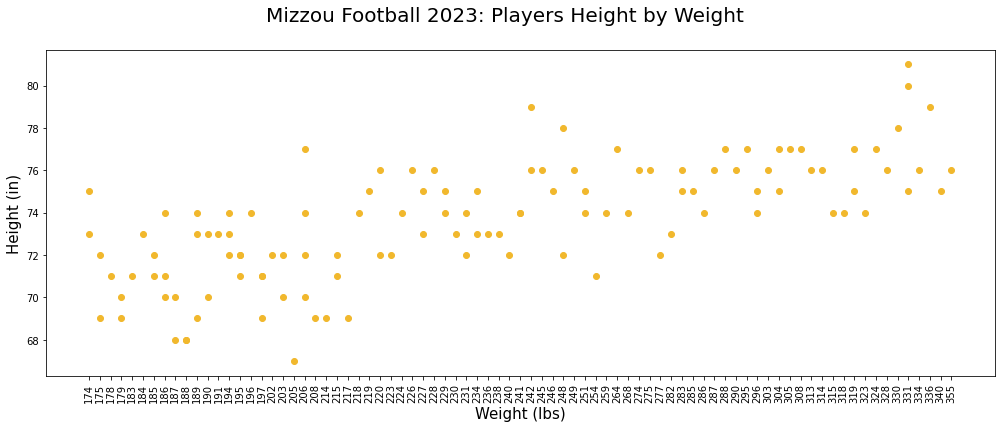

In [18]:
# height by weight scatter plot

#temporary df to prevent error
data_temp = data[data['weight'].notnull() | data['height_inch'].notnull()].sort_values(by = 'weight')

plt.figure(figsize=(17,6))
plt.scatter(data_temp['weight'], data_temp['height_inch'], color = '#F1B82D')
plt.suptitle('Mizzou Football 2023: Players Height by Weight', fontsize = 20)
plt.xticks(rotation = 90)
plt.xlabel("Weight (lbs)", fontsize = 15)
plt.ylabel("Height (in)", fontsize = 15)

plt.show()

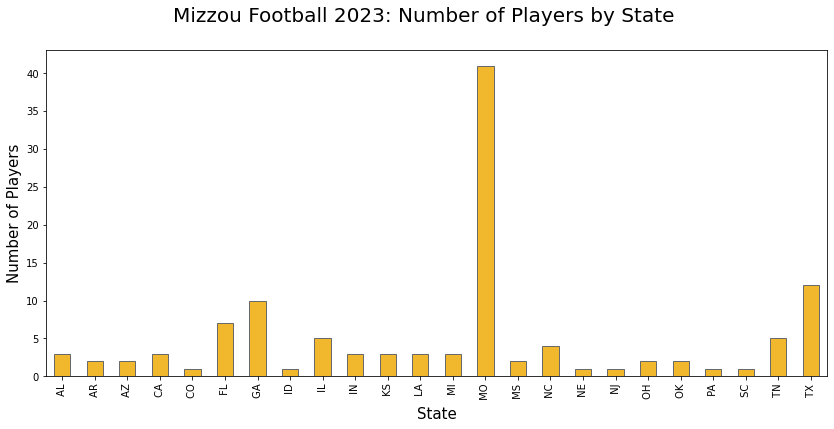

In [19]:
data_temp = data_temp[data_temp['weight'].notnull()]

state_count = data_temp.groupby('home_state')['name'].count().sort_values(ascending = False).sort_index()

state_count.plot.bar(figsize = (14,6), color = '#F1B82D', edgecolor = 'dimgrey')
plt.suptitle('Mizzou Football 2023: Number of Players by State', fontsize = 20)
plt.xlabel("State", fontsize = 15)
plt.ylabel("Number of Players", fontsize = 15)

plt.show()